In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import keras
from numpy import unique
from numpy import reshape
from keras.models import Sequential
from sklearn.model_selection import cross_val_score
from keras.layers import Conv1D, Conv2D, Dense, Dropout, BatchNormalization, Flatten, MaxPooling1D
# from keras.layers.core import Dense, Dropout
from keras.layers import Dense, Dropout
from keras import utils
# from keras.utils import np_utils
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

In [2]:
from keras.models import Sequential
from keras.utils import np_utils
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [5]:
import warnings
warnings.simplefilter('ignore')

# sns.pairplot(X_full[['species', 'sepal_length', 'sepal_width', 'petal_length', 'petal_width']], hue = 'species')
# plt.show()

In [6]:
path = r'C:\Users\Michael\Desktop\Career Foundry\03 Machine Learning\02 Real-World Applications of Machine Learning\Data Sets'

# Import and Resize Data

## Import X data

In [7]:
X_full = pd.read_csv(os.path.join(path,'DATASET weather_prediction_imputed.csv'), index_col = False)

In [8]:
X_full.drop(columns=["YEAR", "MONTH", "DAY"], inplace=True)

### Convert to Array

In [9]:
X_full = X_full.to_numpy()
X_full.shape

(22950, 135)

### Resize to (-1, 15, 9)

In [10]:
X_full = X_full.reshape(-1,15,9)
X_full.shape

(22950, 15, 9)

# Import y data

In [11]:
y_full = pd.read_csv(os.path.join(path,'Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv'), index_col = False)

In [12]:
y_full.drop(columns=["YEAR", "MONTH", "DAY"], inplace=True)

### Convert to array

In [13]:
y_full = y_full.to_numpy()
y_full.shape

(22950, 15)

In [14]:
y_original = y_full

# this is where the change was made

In [33]:
# Use argmax to get rid of on-hot encoding and supply the numerical value.
y_full = np.argmax(y_full, axis = 1)
print(y_full.shape)
y_full

(22950,)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### Remove one hot encoding with argmax

# Split into Test and Train Data

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

In [35]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16065, 15, 9)
(6885, 15, 9)
(16065,)
(6885,)


In [36]:
types = {0:'BASEL_pleasant_weather', 1:'BELGRADE_pleasant_weather',
       2:'BUDAPEST_pleasant_weather', 3:'DEBILT_pleasant_weather',
       4:'DUSSELDORF_pleasant_weather', 5:'HEATHROW_pleasant_weather',
       6:'KASSEL_pleasant_weather', 7:'LJUBLJANA_pleasant_weather',
       8:'MAASTRICHT_pleasant_weather', 9:'MADRID_pleasant_weather',
       10:'MUNCHENB_pleasant_weather', 11:'OSLO_pleasant_weather',
       12:'SONNBLICK_pleasant_weather', 13:'STOCKHOLM_pleasant_weather',
       14:'VALENTIA_pleasant_weather'}

# Optimisation : Bayesian

## y data must be binary or multiclass
## check for data type

In [37]:
from sklearn.utils.multiclass import type_of_target
type_of_target(y_train)

'multiclass'

# old y_data reshaping

In [38]:
# # Turn y_test into one-hot format
# ty=utils.to_categorical(y_test)
# print(ty)

In [39]:
# # Use argmax to get rid of on-hot encoding and supply the numerical value.
# ty = np.argmax(ty, axis = 1)
# print(ty.shape)
# ty

In [40]:
# type_of_target(ty)

# Bayesian Function

In [41]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = 14 #_count_classes(y_train)
# Make scorer accuracy
score_acc = make_scorer(accuracy_score)

In [42]:
# Create function
def bay_area(neurons, activation, kernel, optimizer, learning_rate, batch_size, epochs,
              layers1, layers2, normalization, dropout, dropout_rate): 
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU,'relu']
    
    neurons = round(neurons)
    kernel = round(kernel)
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    batch_size = round(batch_size)
    
    epochs = round(epochs)
    layers1 = round(layers1)
    layers2 = round(layers2)
    
    def cnn_model():
        model = Sequential()
        model.add(Conv1D(neurons, kernel_size=kernel,activation=activation, input_shape=(timesteps, input_dim)))
        #model.add(Conv1D(32, kernel_size=1,activation='relu', input_shape=(timesteps, input_dim)))
        
        if normalization > 0.5:
            model.add(BatchNormalization())
        for i in range(layers1):
            model.add(Dense(neurons, activation=activation)) #(neurons, activation=activation))
        if dropout > 0.5:
            model.add(Dropout(dropout_rate, seed=123))
        for i in range(layers2):
            model.add(Dense(neurons, activation=activation))
        model.add(MaxPooling1D())
        model.add(Flatten())
        model.add(Dense(n_classes, activation='softmax')) #sigmoid softmax
        #model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) #categorical_crossentropy
        model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) #categorical_crossentropy
        return model
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=2, patience=20)
    nn = KerasClassifier(build_fn=cnn_model, epochs=epochs, batch_size=batch_size, verbose=2)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    score = cross_val_score(nn, X_train, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score

In [44]:
start = time.time()
params ={
    'neurons': (10, 100),
    'kernel': (1, 3),
    'activation':(0, 9), #9
    'optimizer':(0,7), #7
    'learning_rate':(0.01, 1),
    'batch_size': (200, 1000), #(10, 50), #
    'epochs':(20, 100),
    'layers1':(1,3),
    'layers2':(1,3),
    'normalization':(0,1),
    'dropout':(0,1),
    'dropout_rate':(0,0.3)
}
# Run Bayesian Optimization
nn_opt = BayesianOptimization(bay_area, params, random_state=42)
nn_opt.maximize(init_points=15, n_iter=4) #25
print('Search took %s minutes' % ((time.time() - start)/60))

|   iter    |  target   | activa... | batch_... |  dropout  | dropou... |  epochs   |  kernel   |  layers1  |  layers2  | learni... |  neurons  | normal... | optimizer |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 1/32
14/14 - 1s - loss: 2.6304 - accuracy: 0.5987 - 1s/epoch - 98ms/step
Epoch 2/32
14/14 - 1s - loss: 2.6318 - accuracy: 0.6423 - 634ms/epoch - 45ms/step
Epoch 3/32
14/14 - 1s - loss: 2.6286 - accuracy: 0.6423 - 618ms/epoch - 44ms/step
Epoch 4/32
14/14 - 1s - loss: 2.6259 - accuracy: 0.6423 - 619ms/epoch - 44ms/step
Epoch 5/32
14/14 - 1s - loss: 2.6235 - accuracy: 0.6423 - 608ms/epoch - 43ms/step
Epoch 6/32
14/14 - 1s - loss: 2.6214 - accuracy: 0.6423 - 633ms/epoch - 45ms/step
Epoch 7/32
14/14 - 1s - loss: 2.6194 - accuracy: 0.6423 - 639ms/epoch - 46ms/step
Epoch 8/32
14/14 - 1s - loss: 2.6175 - accuracy: 0.6423 - 609ms/epoch - 44ms/step
Epoch 9

In [45]:
optimum = nn_opt.max['params']
learning_rate = optimum['learning_rate']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU,'relu']
optimum['activation'] = activationL[round(optimum['activation'])]
optimum['batch_size'] = round(optimum['batch_size'])
optimum['epochs'] = round(optimum['epochs'])
optimum['layers1'] = round(optimum['layers1']) 
optimum['layers2'] = round(optimum['layers2'])
optimum['neurons'] = round(optimum['neurons'])
optimizerL = ['Adam', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','Adam']
optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
             'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
             'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
             'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
optimum['optimizer'] = optimizerD[optimizerL[round(optimum['optimizer'])]]
optimum

{'activation': 'softsign',
 'batch_size': 460,
 'dropout': 0.7296061783380641,
 'dropout_rate': 0.19126724140656393,
 'epochs': 91,
 'kernel': 1.9444298503238986,
 'layers1': 1,
 'layers2': 2,
 'learning_rate': 0.7631771981307285,
 'neurons': 61,
 'normalization': 0.770967179954561,
 'optimizer': <keras.optimizers.legacy.adadelta.Adadelta at 0x1fb812507d0>}

In [46]:
####Need to add learning rate to the optimizer type??

epochs = 91
batch_size = 460
#n_hidden = 32

timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = 14 #_count_classes(y_train)
layers1 = 1
layers2 = 2
activation = 'softsign'
kernel = 2
neurons = 61
normalization = 0.770967179954561
dropout = 0.7296061783380641
dropout_rate = 0.19126724140656393
optimizer = 'Adadelta'

model = Sequential()
model.add(Conv1D(neurons, kernel_size=kernel, activation=activation, input_shape=(timesteps, input_dim)))
if normalization > 0.5:
    model.add(BatchNormalization())
for i in range(layers1):
    model.add(Dense(neurons, activation=activation))
if dropout > 0.5:
    model.add(Dropout(dropout_rate, seed=123))
for i in range(layers2):
    model.add(Dense(neurons, activation=activation))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(n_classes, activation='softmax')) #softmax sigmoid
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) #binary_crossentropy

# Making the confusion matrix

In [47]:
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([activities[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([activities[y] for y in np.argmax(Y_pred, axis=1)])
    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [ ]:
## when using the y_test array it read an error, so I reshaped and this allowed the confusion matrix to run

In [48]:
y_test_origshape = y_test.reshape(-1,15)

In [49]:
y_test_origshape.shape

(459, 15)

In [50]:
 # activities = {
 #     0: 'Unpleasant',
 #     1: 'Pleasant'
 #     }

In [51]:
# activities = {
#     0: "cloud_cover",
#     1: "humidity",
#     2: "pressure",
#     3: "global_radiation",
#     4: "precipitation",
#     5: "sunshine",
#     6: "temp_mean",
#     7: "temp_min",
#     8: "temp_max"}

In [52]:
activities = {
    0: "BASEL",
    1: "BELGRADE",
    2: "BUDAPEST",
    3: "DEBILT",
    4: "DUSSELDORF",
    5: "HEATHROW",
    6: "KASSEL",
    7: "LJUBLJANA",
    8: "MAASTRICHT",
    9: "MADRID",
    10: "MUNCHENB",
    11: "OSLO",
    12: "SONNBLICK",
    13: "STOCKHOLM",
    14: "VALENTIA"
    }

In [ ]:
# The confusion matrix was not as expected. I did not understand why it was not predicting

In [53]:
# Evaluate
print(confusion_matrix(y_test_origshape, model.predict(X_test)))

216/216 [==============================] - 1s 2ms/step
Pred        BASEL  BELGRADE  HEATHROW  KASSEL  LJUBLJANA  MADRID  SONNBLICK
True                                                                       
BASEL           0        15         1      27          1       1          0
BELGRADE        0        13         2      38          3       0          0
BUDAPEST        1        13         1      32          2       0          0
DEBILT          0        11         0      17          0       0          1
DUSSELDORF      0         7         2      16          0       0          1
HEATHROW        0        13         0      20          0       0          0
KASSEL          0        11         0      18          1       0          0
LJUBLJANA       0         9         1      17          0       0          1
MAASTRICHT      0         8         1      17          0       0          1
MADRID          0         4         0      26          0       0          1
MUNCHENB        0         5      

# CNN RELU

In [54]:
def convert(inputx):
  for t_list in inputx:
    for i,h in enumerate(t_list):
      if h==0:
        yield f"{types[i]}".replace("_ple", "_unple")
      else:
        yield f"{types[i]}"

In [55]:
model = Sequential()
model.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=(15,9))) #64
model.add(Dense(32, activation='relu')) #16
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(15, activation='relu')) #3
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_97"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_97 (Conv1D)          (None, 14, 64)            1216      
                                                                 
 dense_479 (Dense)           (None, 14, 32)            2080      
                                                                 
 max_pooling1d_97 (MaxPoolin  (None, 7, 32)            0         
 g1D)                                                            
                                                                 
 flatten_97 (Flatten)        (None, 224)               0         
                                                                 
 dense_480 (Dense)           (None, 15)                3375      
                                                                 
Total params: 6,671
Trainable params: 6,671
Non-trainable params: 0
___________________________________________________

In [56]:
model = Sequential()
model.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=(15,9))) #64
model.add(Dense(16, activation='relu')) #16
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(15, activation='softmax')) #3
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_98 (Conv1D)          (None, 14, 64)            1216      
                                                                 
 dense_481 (Dense)           (None, 14, 16)            1040      
                                                                 
 max_pooling1d_98 (MaxPoolin  (None, 7, 16)            0         
 g1D)                                                            
                                                                 
 flatten_98 (Flatten)        (None, 112)               0         
                                                                 
 dense_482 (Dense)           (None, 15)                1695      
                                                                 
Total params: 3,951
Trainable params: 3,951
Non-trainable params: 0
___________________________________________________

In [57]:
model.fit(X_train,y_train, batch_size=32, epochs=30, verbose=1)
acc = model.evaluate(X_train,y_train) #validation_data=(TeX2, TeY2) <---used for a 3-split test
print('Loss:', acc[0], 'Accuracy', acc[1])

Epoch 1/30
503/503 [==============================] - 2s 2ms/step - loss: 1.0942 - accuracy: 0.6462
Epoch 2/30
503/503 [==============================] - 1s 3ms/step - loss: 0.7847 - accuracy: 0.7349
Epoch 3/30
503/503 [==============================] - 1s 2ms/step - loss: 0.7138 - accuracy: 0.7575
Epoch 4/30
503/503 [==============================] - 1s 2ms/step - loss: 0.6565 - accuracy: 0.7745
Epoch 5/30
503/503 [==============================] - 1s 2ms/step - loss: 0.6302 - accuracy: 0.7815
Epoch 6/30
503/503 [==============================] - 1s 2ms/step - loss: 0.5969 - accuracy: 0.7932
Epoch 7/30
503/503 [==============================] - 1s 2ms/step - loss: 0.5752 - accuracy: 0.7989
Epoch 8/30
503/503 [==============================] - 1s 2ms/step - loss: 0.5514 - accuracy: 0.8059
Epoch 9/30
503/503 [==============================] - 1s 2ms/step - loss: 0.5348 - accuracy: 0.8093
Epoch 10/30
503/503 [==============================] - 1s 2ms/step - loss: 0.5146 - accuracy: 0.8194

In [58]:
model.fit(X_train,y_train,batch_size=32, epochs=10,verbose=1)
acc = model.evaluate(X_train,y_train) #validation_data=(TeX2, TeY2) <---used for a 3-split test
print('Loss:', acc[0], 'Accuracy', acc[1])

Epoch 1/10
503/503 [==============================] - 1s 2ms/step - loss: 0.2904 - accuracy: 0.8959
Epoch 2/10
503/503 [==============================] - 1s 2ms/step - loss: 0.2751 - accuracy: 0.9016
Epoch 3/10
503/503 [==============================] - 1s 2ms/step - loss: 0.2914 - accuracy: 0.8969
Epoch 4/10
503/503 [==============================] - 1s 2ms/step - loss: 0.2624 - accuracy: 0.9058
Epoch 5/10
503/503 [==============================] - 1s 3ms/step - loss: 0.2644 - accuracy: 0.9056
Epoch 6/10
503/503 [==============================] - 1s 2ms/step - loss: 0.3177 - accuracy: 0.8949
Epoch 7/10
503/503 [==============================] - 1s 2ms/step - loss: 0.2454 - accuracy: 0.9136
Epoch 8/10
503/503 [==============================] - 1s 2ms/step - loss: 0.2399 - accuracy: 0.9147
Epoch 9/10
503/503 [==============================] - 1s 2ms/step - loss: 0.2346 - accuracy: 0.9201
Epoch 10/10
503/503 [==============================] - 1s 2ms/step - loss: 0.2410 - accuracy: 0.9111

In [59]:
pred = model.predict(X_test)
#pred_y = pred.argmax(axis=-1)

# Evaluate
print(confusion_matrix(y_test_origshape, pred))#model.predict(TeX2)))

216/216 [==============================] - 0s 1ms/step
Pred        BASEL  BELGRADE  BUDAPEST  DEBILT  DUSSELDORF  HEATHROW  \
True                                                                  
BASEL          37         6         0       0           1         0   
BELGRADE       40        13         1       1           0         0   
BUDAPEST       37         7         1       0           0         0   
DEBILT         21         3         1       1           0         0   
DUSSELDORF     19         7         0       0           0         0   
HEATHROW       24         6         2       0           0         0   
KASSEL         18         7         0       0           0         1   
LJUBLJANA      20         5         0       0           0         0   
MAASTRICHT     19         3         0       1           0         0   
MADRID         19         8         3       0           0         0   
MUNCHENB       20         8         0       0           1         1   
OSLO           11     

# RNN

In [60]:
# locations = list({x.split("_")[0] for x in df_scaled.columns if x not in ["MONTH", "DATE"]})
locations = ["BASEL", "BELGRADE", "BUDAPEST", "DEBILT", 
             "DUSSELDORF", "HEATHROW", "KASSEL", "LJUBLJANA", 
             "MAASTRICHT", "MADRID", "MUNCHENB", "OSLO", 
             "SONNBLICK", "STOCKHOLM", "VALENTIA"]

In [61]:
from tensorflow.keras.layers import SimpleRNN

model = Sequential()
model.add(SimpleRNN(64, input_shape=(15, 9), activation='relu'))
model.add(Dense(15, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'),
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')])

## Reload and Resplit Data for the Next Model

In [63]:
X_full = pd.read_csv(os.path.join(path,'DATASET weather_prediction_imputed.csv'), index_col = False)
X_full.drop(columns=["YEAR", "MONTH", "DAY"], inplace=True)
X_full = X_full.to_numpy()
X_full = X_full.reshape(-1,15,9)
print(X_full.shape)

y_full = pd.read_csv(os.path.join(path,'Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv'), index_col = False)
y_full.drop(columns=["YEAR", "MONTH", "DAY"], inplace=True)
y_full = y_full.to_numpy()
print(y_full.shape)

(22950, 15, 9)
(22950, 15)


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(16065, 15, 9) (6885, 15, 9)
(16065, 15) (6885, 15)


In [66]:
model.fit(X_train, y_train, epochs=43)

Epoch 1/43
503/503 [==============================] - 4s 6ms/step - loss: 0.3297 - tp: 33039.0000 - fp: 17733.0000 - tn: 171172.0000 - fn: 19031.0000 - accuracy: 0.8474 - precision: 0.6507 - recall: 0.6345 - auc: 0.9020
Epoch 2/43
503/503 [==============================] - 3s 6ms/step - loss: 0.2269 - tp: 38866.0000 - fp: 12174.0000 - tn: 176731.0000 - fn: 13204.0000 - accuracy: 0.8947 - precision: 0.7615 - recall: 0.7464 - auc: 0.9517
Epoch 3/43
503/503 [==============================] - 3s 6ms/step - loss: 0.2081 - tp: 40115.0000 - fp: 11155.0000 - tn: 177750.0000 - fn: 11955.0000 - accuracy: 0.9041 - precision: 0.7824 - recall: 0.7704 - auc: 0.9598
Epoch 4/43
503/503 [==============================] - 3s 6ms/step - loss: 0.1948 - tp: 41065.0000 - fp: 10308.0000 - tn: 178597.0000 - fn: 11005.0000 - accuracy: 0.9116 - precision: 0.7993 - recall: 0.7886 - auc: 0.9650
Epoch 5/43
503/503 [==============================] - 3s 6ms/step - loss: 0.1846 - tp: 41922.0000 - fp: 9845.0000 - tn: 

In [67]:
scores = model.predict(X_test)

216/216 [==============================] - 1s 3ms/step


In [68]:
lst = []
for n in range(len(scores)):
    lst.append([int(round(elem, 0)) for elem in list(scores[n])])

In [69]:
lst = np.array(lst)
y_prediction = pd.DataFrame({'BASEL': lst[:, 0], 'BELGRADE': lst[:, 1],
                             'BUDAPEST': lst[:, 2],'DEBILT': lst[:, 3],
                             'DUSSELDORF': lst[:, 4],'HEATHROW': lst[:, 5],
                             'KASSEL': lst[:, 6],'LJUBLJANA': lst[:, 7],
                             'MAASTRICHT': lst[:, 8],'MADRID': lst[:, 9],
                             'MUNCHENB': lst[:, 10],'OSLO': lst[:, 11],
                             'SONNBLICK': lst[:, 12],'STOCKHOLM': lst[:, 13],
                             'VALENTIA': lst[:, 14]})

y_test = np.array(y_test)
y_testframe = pd.DataFrame({'BASEL': y_test[:, 0], 'BELGRADE': y_test[:, 1],
                            'BUDAPEST': y_test[:, 2],'DEBILT': y_test[:, 3],
                            'DUSSELDORF': y_test[:, 4],'HEATHROW': y_test[:, 5],
                            'KASSEL': y_test[:, 6],'LJUBLJANA': y_test[:, 7],
                            'MAASTRICHT': y_test[:, 8],'MADRID': y_test[:, 9],
                            'MUNCHENB': y_test[:, 10],'OSLO': y_test[:, 11],
                            'SONNBLICK': y_test[:, 12],'STOCKHOLM': y_test[:, 13],
                            'VALENTIA': y_test[:, 14]})

In [70]:
y_testframe.head()

,BASEL,BELGRADE,BUDAPEST,DEBILT,DUSSELDORF,HEATHROW,KASSEL,LJUBLJANA,MAASTRICHT,MADRID,MUNCHENB,OSLO,SONNBLICK,STOCKHOLM,VALENTIA
0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,1,0,0,0,1,1,0,0,0,0
3,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [71]:
y_prediction.head()

,BASEL,BELGRADE,BUDAPEST,DEBILT,DUSSELDORF,HEATHROW,KASSEL,LJUBLJANA,MAASTRICHT,MADRID,MUNCHENB,OSLO,SONNBLICK,STOCKHOLM,VALENTIA
0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,1,0,0,0,1,1,0,0,0,0
3,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [72]:
y_prediction.nunique()

BASEL         2
BELGRADE      2
BUDAPEST      2
DEBILT        2
DUSSELDORF    2
HEATHROW      2
KASSEL        2
LJUBLJANA     2
MAASTRICHT    2
MADRID        2
MUNCHENB      2
OSLO          2
SONNBLICK     1
STOCKHOLM     2
VALENTIA      2
dtype: int64

In [91]:
print(y_test)

[[1 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [115]:
def confusion_matrix2(Y_true, Y_pred):
    Y_true = pd.Series([activities[y] for y in np.argmax(Y_true, axis=0)])
    Y_pred = pd.Series([activities[y] for y in np.argmax(Y_pred, axis=0)])
    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

TypeError: 'numpy.int64' object is not iterable

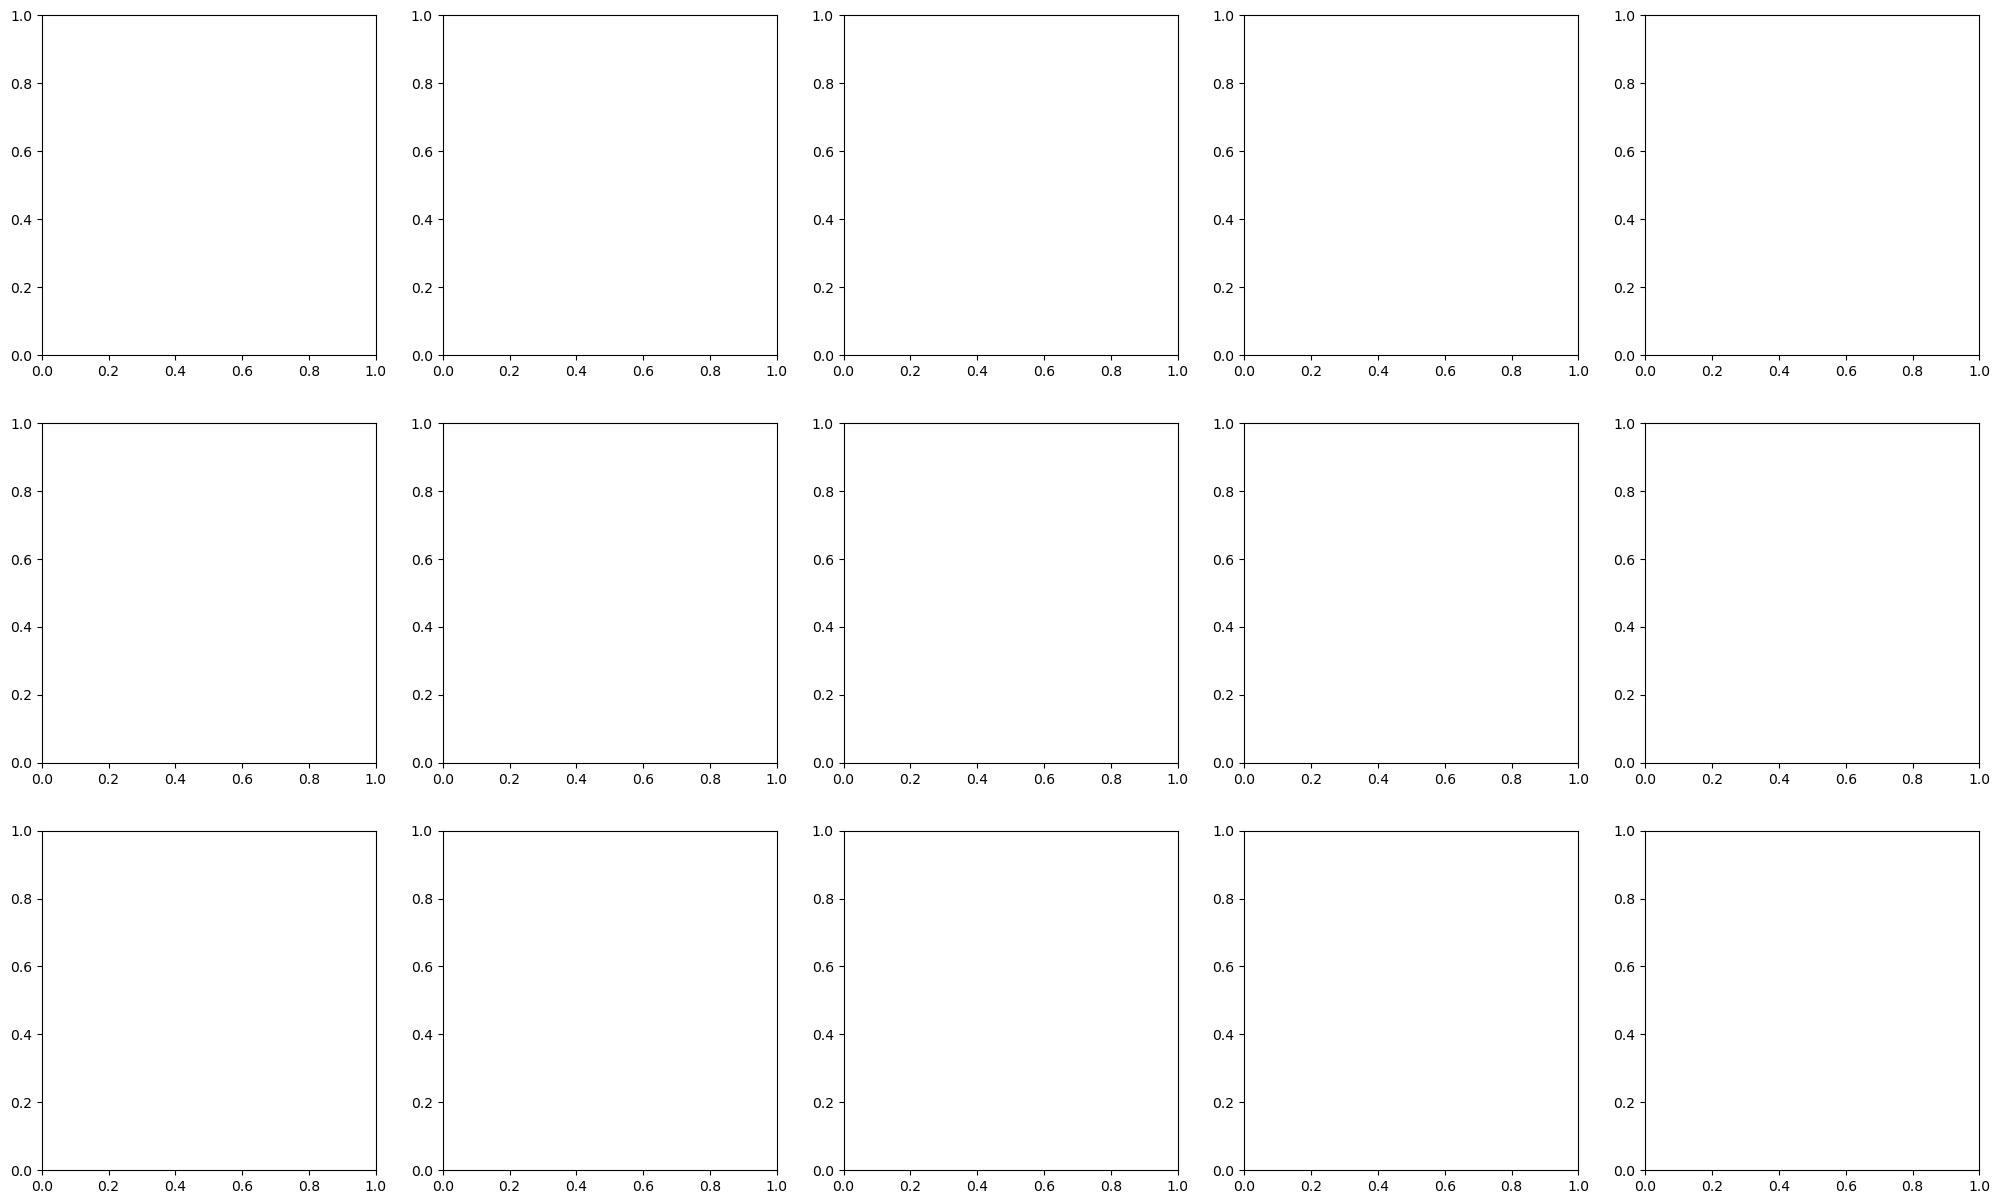

In [122]:
f, axes = plt.subplots(3, 5, figsize=(25, 15))
axes = axes.ravel()
for i in range(15):
    # if i==12:
    #     labels = [0]
    # else:
    #     labels = [0,1]
    
    disp = ConfusionMatrixDisplay(confusion_matrix2(y_test[:, i], lst[:, i])
                                  #, display_labels=labels)
                                 )

    disp.plot(ax=axes[i], values_format='.4g')
    
    disp.ax_.set_title(locations[i])
    
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()